## NLP Code

This notebook is for writing the Natural Language Processing code that will go inside of the program function.
Requirements:
- tokenize text
- remove stop words
- stem tokens
- produce counts of most frequently used tokens and bi-grams

### Implementation Overview:
1. Import word document of job description
2. Generate stopword lists:  English list and custom list 
3. Apply tokenizer to strip puncuation, remove stopwords, and create bag of words
4. Create a dictionary of skills from word bag
5. Create a dictionary of stemmed skills from word bag
6. Create a third dictionary with counts of unstemmed words for each word stem
7. Visualize results 

#### Next Steps:
- Transpose second and third dictionaries into DataFrame
- Repeat processing for bi- and tri-grams*
- Update DataFrame with results of bi- and tri-grams analysis

**For bi- and tri-gram analysis, only remove English stopwords and omit results containing stemmed versions of custom stopwords.* 



In [8]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textract as tx
import nltk
from nltk.corpus import stopwords 
import string

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

## Step 1 - Import Job Document

Import word document with job description.

In [9]:
# import word document and decode bytes into string data
job_corpus = tx.process("skills_sample.docx").decode("utf-8")

# remove all line breaks and non-breaking spaces
job_corpus = job_corpus.replace(
    '\n', ' ').replace(
        '\xa0', ' ').replace(
            '\r', ' '
        )

# return text string
job_corpus

'Adaptability: Flexibility and adaptability to learn new tools, techniques, and technologies as needed to support evolving business needs.  Attention to Detail: Strong attention to detail and accuracy in data analysis and reporting to ensure the reliability and integrity of findings.  Strong problem-solving, logical thinking and analytical skills.  Proficiency in computer skills including Excel, PowerPoint, and mapping software.  Statistical Knowledge: Solid understanding of statistical concepts and methods for data analysis, such as regression analysis, hypothesis testing, and time series analysis.  Communication Skills: Excellent verbal and written communication skills with the ability to effectively present findings and recommendations to both technical and non-technical audiences.  Team Collaboration: Ability to work collaboratively in a cross-functional team environment and effectively communicate with stakeholders at all levels of the organization.  Time Management: Ability to ma

## Step 2 - Generate Stopword Lists

Two lists two generate:  the first will be the standard English stopwords, the second will be a custom list of terms commonly found in job description headings and common verbs that do not add value to analysis.

### English Stopwords:

In [10]:
# initialize stemmer
stemmer = nltk.stem.PorterStemmer()

# download the nltk stopwords
nltk.download('stopwords')

# assign english stop words to variable
eng_sw = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taylo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Custom Stopwords:

In [11]:
cust_sw = ["experience", "education", "skills", "responsibilities", "duties", "tasks",
           "overview", "candidate", "profile", "competencies", "benefits", "abilities"]

## Step 3 - Apply Tokenizer

Define custom tokenizer to strip punctuation, format all text to lowercase, remove stopwords and split string into individual tokens.  Return bag of words.

In [12]:
# custom tokenizer definition
def my_tokenizer(corpus):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        corpus = corpus.replace(punctuation_mark,'').lower()

    # split string into words
    listofwords = corpus.split(' ')
    wordbag = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in eng_sw) and (not word in cust_sw) and (word!=''):
            wordbag.append(word)

    return wordbag

In [13]:
# a dummy sentence used for checking our process
#test_sent = "The quick brown fox, jumped over the lazy, lazy dog!!"

In [14]:
# apply tokenizer
bagofskills = my_tokenizer(job_corpus)
print(bagofskills)

['adaptability', 'flexibility', 'adaptability', 'learn', 'new', 'tools', 'techniques', 'technologies', 'needed', 'support', 'evolving', 'business', 'needs', 'attention', 'detail', 'strong', 'attention', 'detail', 'accuracy', 'data', 'analysis', 'reporting', 'ensure', 'reliability', 'integrity', 'findings', 'strong', 'problemsolving', 'logical', 'thinking', 'analytical', 'proficiency', 'computer', 'including', 'excel', 'powerpoint', 'mapping', 'software', 'statistical', 'knowledge', 'solid', 'understanding', 'statistical', 'concepts', 'methods', 'data', 'analysis', 'regression', 'analysis', 'hypothesis', 'testing', 'time', 'series', 'analysis', 'communication', 'excellent', 'verbal', 'written', 'communication', 'ability', 'effectively', 'present', 'findings', 'recommendations', 'technical', 'nontechnical', 'audiences', 'team', 'collaboration', 'ability', 'work', 'collaboratively', 'crossfunctional', 'team', 'environment', 'effectively', 'communicate', 'stakeholders', 'levels', 'organiza

## Step 4 - Create Dictionary of SKills

Create a dictionary that counts each time a skill is used in the corpus.

In [15]:
# create dictionary of words from the tokens returned by tokenizer
skill_dict = dict((x, bagofskills.count(x)) for x in list(bagofskills))

skill_dict

{'adaptability': 2,
 'flexibility': 1,
 'learn': 1,
 'new': 1,
 'tools': 1,
 'techniques': 1,
 'technologies': 1,
 'needed': 1,
 'support': 1,
 'evolving': 1,
 'business': 1,
 'needs': 1,
 'attention': 2,
 'detail': 2,
 'strong': 2,
 'accuracy': 1,
 'data': 2,
 'analysis': 4,
 'reporting': 1,
 'ensure': 1,
 'reliability': 1,
 'integrity': 1,
 'findings': 2,
 'problemsolving': 1,
 'logical': 1,
 'thinking': 1,
 'analytical': 1,
 'proficiency': 1,
 'computer': 1,
 'including': 1,
 'excel': 1,
 'powerpoint': 1,
 'mapping': 1,
 'software': 1,
 'statistical': 2,
 'knowledge': 1,
 'solid': 1,
 'understanding': 1,
 'concepts': 1,
 'methods': 1,
 'regression': 1,
 'hypothesis': 1,
 'testing': 1,
 'time': 2,
 'series': 1,
 'communication': 2,
 'excellent': 1,
 'verbal': 1,
 'written': 1,
 'ability': 3,
 'effectively': 3,
 'present': 1,
 'recommendations': 1,
 'technical': 1,
 'nontechnical': 1,
 'audiences': 1,
 'team': 2,
 'collaboration': 1,
 'work': 1,
 'collaboratively': 1,
 'crossfunctiona

In [16]:
# check the length
len(skill_dict)

74

## Step 5 - Create Dictionary of Stemmed Words

Stem the tokens in the word bag and create a dictionary of stemmed words.

In [17]:
# empty list for stemmed bag of words
stemmed_wordbag = []

# fill stemmed bag of words
for word in bagofskills:
    stemmed_word = stemmer.stem(word)
    stemmed_wordbag.append(stemmed_word)

In [18]:
# create dictionary of words from the tokens returned by tokenizer
stem_dict = dict((x, stemmed_wordbag.count(x)) for x in list(stemmed_wordbag))

stem_dict

{'adapt': 2,
 'flexibl': 1,
 'learn': 1,
 'new': 1,
 'tool': 1,
 'techniqu': 1,
 'technolog': 1,
 'need': 2,
 'support': 1,
 'evolv': 1,
 'busi': 1,
 'attent': 2,
 'detail': 2,
 'strong': 2,
 'accuraci': 1,
 'data': 2,
 'analysi': 4,
 'report': 1,
 'ensur': 1,
 'reliabl': 1,
 'integr': 1,
 'find': 2,
 'problemsolv': 1,
 'logic': 1,
 'think': 1,
 'analyt': 1,
 'profici': 1,
 'comput': 1,
 'includ': 1,
 'excel': 2,
 'powerpoint': 1,
 'map': 1,
 'softwar': 1,
 'statist': 2,
 'knowledg': 1,
 'solid': 1,
 'understand': 1,
 'concept': 1,
 'method': 1,
 'regress': 1,
 'hypothesi': 1,
 'test': 1,
 'time': 2,
 'seri': 1,
 'commun': 3,
 'verbal': 1,
 'written': 1,
 'abil': 3,
 'effect': 3,
 'present': 1,
 'recommend': 1,
 'technic': 1,
 'nontechn': 1,
 'audienc': 1,
 'team': 2,
 'collabor': 2,
 'work': 1,
 'crossfunct': 1,
 'environ': 2,
 'stakehold': 1,
 'level': 1,
 'organ': 1,
 'manag': 2,
 'multipl': 1,
 'project': 1,
 'prioriti': 1,
 'fastpac': 1,
 'meet': 1,
 'deadlin': 1}

In [19]:
# check the length
len(stem_dict)

69

### Check Dictionary Contents:

Confirm that both dicutionaries contain the same number of overall terms

In [20]:
terms = 0
stems = 0

for key in skill_dict:
    terms += skill_dict[key]

for key in stem_dict:
    stems += stem_dict[key]

print(f"Number of terms in skills dictionary:           {terms}")
print(f"Number of terms in stemmed skills dictionary:   {stems}")

Number of terms in skills dictionary:           92
Number of terms in stemmed skills dictionary:   92


Dictionaries have equal number of terms.

## Step 6 - Create Stemmed Skills Dictionary of Skills

Now we want to create a final dictionary where the stemmed skills are passed as keys and the value pairs are subdictionaries of the unstemmed skills.

In [21]:
# initialize empty dictionary
stem_skills_dict = {key: {} for key in stem_dict}


In [22]:
# fill dictionary
for word in bagofskills:
    stemmed_word = stemmer.stem(word)
    word_count = bagofskills.count(word)
    stem_skills_dict[stemmed_word][word] = word_count

In [23]:
stem_skills_dict

{'adapt': {'adaptability': 2},
 'flexibl': {'flexibility': 1},
 'learn': {'learn': 1},
 'new': {'new': 1},
 'tool': {'tools': 1},
 'techniqu': {'techniques': 1},
 'technolog': {'technologies': 1},
 'need': {'needed': 1, 'needs': 1},
 'support': {'support': 1},
 'evolv': {'evolving': 1},
 'busi': {'business': 1},
 'attent': {'attention': 2},
 'detail': {'detail': 2},
 'strong': {'strong': 2},
 'accuraci': {'accuracy': 1},
 'data': {'data': 2},
 'analysi': {'analysis': 4},
 'report': {'reporting': 1},
 'ensur': {'ensure': 1},
 'reliabl': {'reliability': 1},
 'integr': {'integrity': 1},
 'find': {'findings': 2},
 'problemsolv': {'problemsolving': 1},
 'logic': {'logical': 1},
 'think': {'thinking': 1},
 'analyt': {'analytical': 1},
 'profici': {'proficiency': 1},
 'comput': {'computer': 1},
 'includ': {'including': 1},
 'excel': {'excel': 1, 'excellent': 1},
 'powerpoint': {'powerpoint': 1},
 'map': {'mapping': 1},
 'softwar': {'software': 1},
 'statist': {'statistical': 2},
 'knowledg': 

## Step 7 - Visualize Results

Graphically visualize the top 20 most common skill stems.

### Skills:

In [24]:
skill_df = pd.DataFrame(skill_dict.values(), columns=["Count"], index=skill_dict.keys())
df_sorted = skill_df.sort_values(by="Count", ascending=True)
top_skills = df_sorted.tail(20)

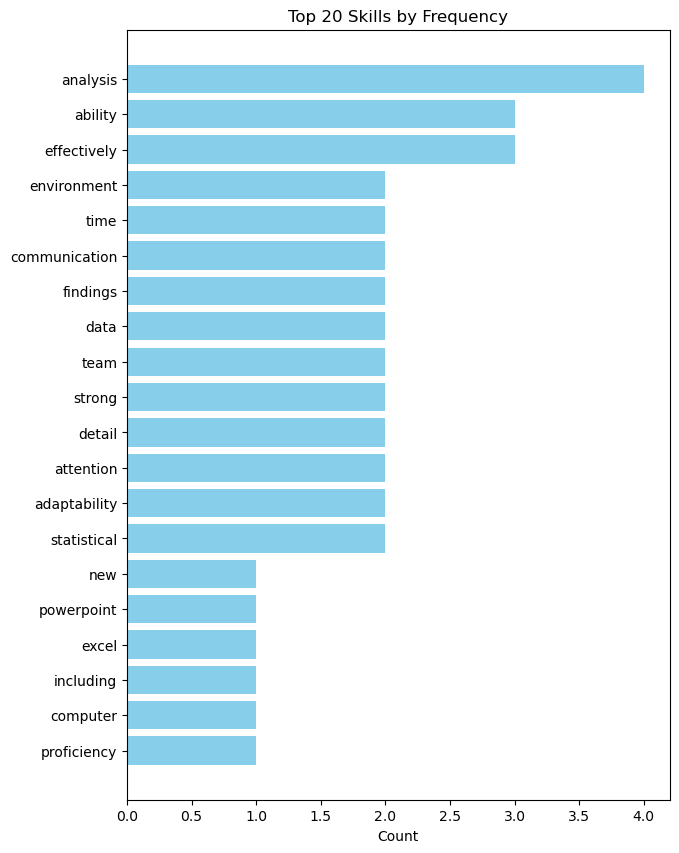

In [25]:
plt.figure(figsize=(7, 10))
plt.barh(top_skills.index, top_skills["Count"], color='skyblue')
#word_count_df.head(20).plot(kind='barh', legend=False)
plt.title("Top 20 Skills by Frequency")
plt.xlabel("Count")
plt.show()

### Stems:

In [26]:
stem_df = pd.DataFrame(stem_dict.values(), columns=["Count"], index=stem_dict.keys())
df_sorted = stem_df.sort_values(by="Count", ascending=True)
top_stems = df_sorted.tail(20)

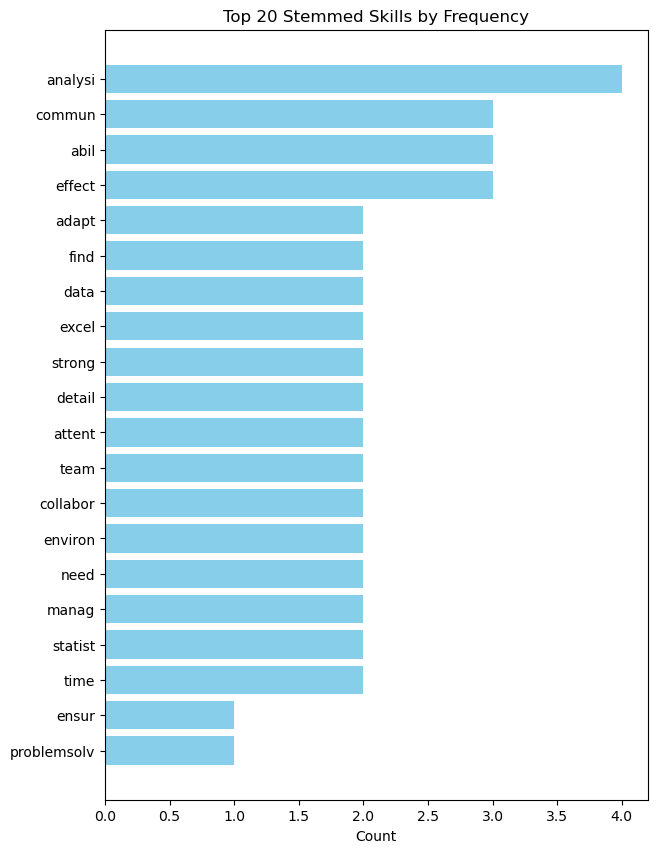

In [27]:
plt.figure(figsize=(7, 10))
plt.barh(top_stems.index, top_stems["Count"], color='skyblue')
#word_count_df.head(20).plot(kind='barh', legend=False)
plt.title("Top 20 Stemmed Skills by Frequency")
plt.xlabel("Count")
plt.show()

# Part 2 - Implement Bigrams

Part 2 of the process is implementing bigrams analysis of the text corpus to assess so that commonly used pairs of words can be returned in the list of frequently appearing skills and keywords.  This should ensure that skills such as "business intelligence" are captured by the program, as this pair of words ascribes meaning that would not be directly conferred by either of those words individually.

Here is the general process to be applied:
1. Create a second tokenizer function that only removes the English stopwords, and does not apply stemming
2. Generate Bigrams from the text
3. Fill dictionary with Bigrams and frequency of appearance
4. Visualize Results

Next Steps:
1. Remove dictionary entries where the Bigram key contains any words from the custom stopword list

## Step 1 - Implement New Tokenizer Function

Recall that we already have the text string of the job document stored in `job_corpus`, therefore we do not need to import the document again.  However, we do need to setup a second tokenizer function that will remove punctuation, split the text into tokens, and remove the English stopwords.  The custom stopwords will not be removed at this point, nor will the tokens be stemmed.

In [28]:
# custom tokenizer definition
def my_tokenizer_2(corpus):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        corpus = corpus.replace(punctuation_mark,'').lower()

    # split string into words
    listofwords = corpus.split(' ')
    wordbag = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in eng_sw) and (word!=''):
            wordbag.append(word)

    return wordbag

In [36]:
# apply tokenizer
bagofwords2 = my_tokenizer_2(job_corpus)
print(bagofwords2)

['adaptability', 'flexibility', 'adaptability', 'learn', 'new', 'tools', 'techniques', 'technologies', 'needed', 'support', 'evolving', 'business', 'needs', 'attention', 'detail', 'strong', 'attention', 'detail', 'accuracy', 'data', 'analysis', 'reporting', 'ensure', 'reliability', 'integrity', 'findings', 'strong', 'problemsolving', 'logical', 'thinking', 'analytical', 'skills', 'proficiency', 'computer', 'skills', 'including', 'excel', 'powerpoint', 'mapping', 'software', 'statistical', 'knowledge', 'solid', 'understanding', 'statistical', 'concepts', 'methods', 'data', 'analysis', 'regression', 'analysis', 'hypothesis', 'testing', 'time', 'series', 'analysis', 'communication', 'skills', 'excellent', 'verbal', 'written', 'communication', 'skills', 'ability', 'effectively', 'present', 'findings', 'recommendations', 'technical', 'nontechnical', 'audiences', 'team', 'collaboration', 'ability', 'work', 'collaboratively', 'crossfunctional', 'team', 'environment', 'effectively', 'communica

## Step 2 - Generate Ngrams

We care about pairs of words and short phrases that are commonly occurring in the job description.  Create a list of Ngrams from the text for N = 2,3.

In [29]:
from nltk.util import bigrams

In [41]:
# create list of bigrams
bagofgrams = list(bigrams(bagofwords2))

# check first 10 entries
bagofgrams[0:10]


[('adaptability', 'flexibility'),
 ('flexibility', 'adaptability'),
 ('adaptability', 'learn'),
 ('learn', 'new'),
 ('new', 'tools'),
 ('tools', 'techniques'),
 ('techniques', 'technologies'),
 ('technologies', 'needed'),
 ('needed', 'support'),
 ('support', 'evolving')]

## Step 3 - Populate Bigram Dictionary

In [42]:
# create dictionary of bigrams from the tokens returned by tokenizer
bigram_dict = dict((x, bagofgrams.count(x)) for x in bagofgrams)

# check dictionary contents
bigram_dict

{('adaptability', 'flexibility'): 1,
 ('flexibility', 'adaptability'): 1,
 ('adaptability', 'learn'): 1,
 ('learn', 'new'): 1,
 ('new', 'tools'): 1,
 ('tools', 'techniques'): 1,
 ('techniques', 'technologies'): 1,
 ('technologies', 'needed'): 1,
 ('needed', 'support'): 1,
 ('support', 'evolving'): 1,
 ('evolving', 'business'): 1,
 ('business', 'needs'): 1,
 ('needs', 'attention'): 1,
 ('attention', 'detail'): 2,
 ('detail', 'strong'): 1,
 ('strong', 'attention'): 1,
 ('detail', 'accuracy'): 1,
 ('accuracy', 'data'): 1,
 ('data', 'analysis'): 2,
 ('analysis', 'reporting'): 1,
 ('reporting', 'ensure'): 1,
 ('ensure', 'reliability'): 1,
 ('reliability', 'integrity'): 1,
 ('integrity', 'findings'): 1,
 ('findings', 'strong'): 1,
 ('strong', 'problemsolving'): 1,
 ('problemsolving', 'logical'): 1,
 ('logical', 'thinking'): 1,
 ('thinking', 'analytical'): 1,
 ('analytical', 'skills'): 1,
 ('skills', 'proficiency'): 1,
 ('proficiency', 'computer'): 1,
 ('computer', 'skills'): 1,
 ('skills', '

## Step 4 - Visualize Results

In [49]:
gram_df = pd.DataFrame(bigram_dict.values(), columns=["Count"], index=bigram_dict.keys())
gram_df = gram_df.sort_values(by="Count", ascending=False)
top_grams = gram_df.head(20)
print(top_grams)

                                 Count
attention       detail               2
data            analysis             2
communication   skills               2
adaptability    flexibility          1
audiences       team                 1
nontechnical    audiences            1
technical       nontechnical         1
recommendations technical            1
findings        recommendations      1
present         findings             1
effectively     present              1
ability         effectively          1
skills          ability              1
collaboration   ability              1
written         communication        1
verbal          written              1
excellent       verbal               1
skills          excellent            1
analysis        communication        1
series          analysis             1
